In [1]:
# import os
# import astropy
# import scipy
# import matplotlib
# import dust_extinction

In [2]:
def doppler_shift(miu,Vorb,vr):
    """
    Relativistic Doppler shifit
    """
    #return miu
    import numpy as np
    c=2.99792e5
    return miu*np.sqrt(1-Vorb**2/c**2)/(1+vr/c)
def phot_E(Vorb,vr,Fre,Hnu,WL,Wl,Wr,PB_curve,ebv):
    """
    Beaming flux at Energy counter detector
    """
    from astropy import coordinates as coord, units as u
    from dust_extinction.parameter_averages import F19
    import numpy as np
    from scipy import interpolate
    ext=F19(Rv=3.1)
    c=2.99792e5
    
    fre=doppler_shift(Fre,Vorb,vr)
    wave=c/fre*1e13
    D=np.sqrt(1-Vorb**2/c**2)/(1+vr/c)
    flamda=4*Hnu*c/(1/fre)**2*D**3
    f_sp=interpolate.interp1d(wave,flamda,kind='quadratic')
    flux=f_sp(WL)*ext.extinguish(WL*u.AA,Av=ebv*3.1)
    return sum(flux*PB_curve)
def phot_P(Vorb,vr,Fre,Hnu,WL,Wl,Wr,PB_curve,ebv):
    """
    Beaming flux at photon counter detector
    """
    from astropy import coordinates as coord, units as u
    from dust_extinction.parameter_averages import F19
    import numpy as np
    from scipy import interpolate
    ext=F19(Rv=3.1)
    c=2.99792e5
    
    fre=doppler_shift(Fre,Vorb,vr)
    wave=c/fre*1e13
    D=np.sqrt(1-Vorb**2/c**2)/(1+vr/c)
    flamda=4*Hnu*c/(1/fre)**2*D**3
    f_sp=interpolate.interp1d(wave,flamda,kind='quadratic')
    flux=f_sp(WL)*ext.extinguish(WL*u.AA,Av=ebv*3.1)
    return sum(flux*PB_curve*WL)
def Linear(x,k,b):
    return x*k+b

In [3]:
def To_Air(wave):
    """
    Convert wavelength from VAC to AIR
    (wave in \AA)
    Reference: https://iopscience.iop.org/article/10.1086/377639/pdf
    
    """
    sig=10**4/wave
    return wave/(1+ 8.06051e-5+2.480990e-2/(132.274-sig**2)+(1.74557e-4/(39.32957-sig**2)))

In [4]:
def ReadSpec(specfile=None,spectype=None):
    """
    Read local spectra file. Supported spectype included: ATLAS9,PHOENIX,TMAP
    Example:
        ReadSpec(specfile='/path/to/file/fp05hep02t40000g45k2odfnew.dat',spectype='ATLAS9')
    Atlas9:
        Flambda=4*Hnu*c/wavelength^2
    """
    c=2.99792e5
    import numpy as np
    import os
    if specfile==None:
        raise KeyError(f'Undefined name of spectral file')
    if not os.path.exists(specfile):
        raise FileNotFoundError(f'File Not Found: \'{specfile}\'')
    if spectype not in ['ATLAS9','PHOENIX','TMAP','USER']:
        raise KeyError(f'Undefined type of \'{specfile}\', please define with spectype={{\'ATLAS9\',\'PHOENIX\',\'TMAP\',\'USER\'}}')

    if spectype=='ATLAS9':
        data=open(specfile,'r').readlines()
        wave=[]
        hnu=[]
        for row in data[2:-5]:
            tem=row.split()
            wave.append(float(tem[2])*10)
            hnu.append(float(tem[4]))
        wave=np.array(wave)
        hnu=np.array(hnu)
        flux=4*hnu*c/wave**2
        return wave,flux
    if spectype=='PHOENIX':
        from astropy.io import fits
        fpath=os.path.join(os.path.dirname(__file__),'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
        wave=fits.open(fpath)[0].data
        flux=fits.open(specfile)[0].data
        return wave,flux
    if spectype=='TMAP':
        data=open(specfile,'r').readlines()
        tem0=''
        for row in data:
            if '*' == row[0]:
                continue
            if row == tem0:
                continue
            wave.append(float(row.rstrip('\n').split()[0]))
            flux.append(float(row.rstrip('\n').split()[1]))
        wave=np.array(wave)
        flux=np.array(flux)
        #flux=flux/1e15
        return wave,flux
    if spectype=='USER':
        data=open(specfile,'r').readlines()
        if data[0][0]=='#':
            sign=1
        else:
            sign=0
        wave=np.array([float(i.rstrip('\n').split()[0]) for i in data[sign:]])
        flux=np.array([float(i.rstrip('\n').split()[1]) for i in data[sign:]])
        return wave,flux

In [5]:
def plot_spec(WAVE,FLUX,pb,trans):
    import matplotlib.pyplot as plt
    INDEX=(WAVE>min(pb)) & (WAVE<max(pb))
    WAVE=WAVE[INDEX]
    FLUX=FLUX[INDEX]
    plt.plot(WAVE,FLUX/max(FLUX))
    plt.plot(pb,trans/max(trans))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [6]:
def ReadFilter(band,bandfile,bandtype):
    """
    Support filter names: u,g,r,i,z,
    """
    import os
    if band==None:
        raise KeyError(f'Undefined filter passband.')
    LOG={'u': 'SLOAN_SDSS.u.dat.P',
        'g': 'SLOAN_SDSS.g.dat.P',
        'r': 'SLOAN_SDSS.r.dat.P',
        'i': 'SLOAN_SDSS.i.dat.P',
        'z':'SLOAN_SDSS.z.dat.P',
        'TESS':'TESS_TESS.Red.dat.E',
        'G':'GAIA_GAIA3.G.dat.P',
        'Gbp':'GAIA_GAIA3.Gbp.dat.P',
        'Grp':'GAIA_GAIA3.Grp.dat.P',
        'U':'Generic_Bessell.U.dat.E',
        'B': 'Generic_Bessell.B.dat.E',
        'V': 'Generic_Bessell.V.dat.E',
        'R':'Generic_Bessell.R.dat.E',
        'I':'Generic_Bessell.I.dat.E',
        'kepler':'Kepler_Kepler.K.dat.P',
        'NUV_CSST': 'NUV_throughput.txt.P',
        'u_c': 'u_throughput.txt.P',
        'g_c':'g_throughput.txt.P',
        'r_c':'r_throughput.txt.P',
        'i_c':'i_throughput.txt.P',
        'z_c':'z_throughput.txt.P',
        'y_c': 'y_throughput.txt.P',
        'USER':bandfile}
    if band not in LOG:
        raise KeyError(f'Undsupported filter name:{band}')
    if band == 'USER' and bandfile==None:
        raise KeyError(f'Undefined bandfile.')
    if band=='USER':
        data=open(bandfile,'r').readlines()
    else:
        fpath=os.path.join(os.path.dirname(__file__),'PassBandFile',LOG[band])
        data=open(fpath,'r').readlines()
        bandtype=LOG[band].split('.')[-1]
    if data[0][0]=='#':
        sign=1
    else:
        sign=0
    import numpy as np
    wave=np.array([float(i.rstrip('\n').split()[0]) for i in data[sign:]])
    flux=np.array([float(i.rstrip('\n').split()[1]) for i in data[sign:]])
    return wave,flux,bandtype

In [7]:
def factor(specfile=None,spectype=None,showspec=False,convert_air=False,band=None,bandfile=None,bandtype='E',
          RV_min=None,RV_max=None,K=None,V0=0,e=0,omega=0,ebv=0,Constant_Factor=True,Dindex=None,plot_beaming=False):
    from scipy import interpolate
    """
    Users can specific their own flux calibrated spectra
    (in ascii format, first column being wavelength in Angstorm and second column being flux,seperated by comma.
    First line can be comments begin with '#'.)
    or synthetic spectra (direct download from PHOENIX, Atlas9, or TMAP).
    Supported spectype included: ATLAS9, PHOENIX, TMAP, and USER.
    
    Filter name should be given with band='Filter_Name'.
    Support Filter_Name: u,g,r,i,z,TESS,G,Gbp,Grp,U,B,V,R,I,kepler,NUV_CSST,u_c,g_c,r_c,i_c,z_c,y_c
    Example:
        factor(specfile='/path/to/file/file_name',spectype='ATLAS9')    
    
    """
    import numpy as np
    from scipy import interpolate
    from scipy.optimize import curve_fit
    c=2.99792e5
    WAVE,FLUX=ReadSpec(specfile=specfile,spectype=spectype)
    PB_x,Trans,bandtype=ReadFilter(band,bandfile,bandtype)
    
    WL=np.arange(min(PB_x),max(PB_x),0.005)
    f_t=interpolate.interp1d(PB_x,Trans,kind='quadratic')
    WP=f_t(WL)
    INDEX0=(WAVE>min(PB_x)-100) & (WAVE<max(PB_x)+100)
    wave0=WAVE[INDEX0]
    flux0=FLUX[INDEX0]
    
    if showspec:
        plot_spec(WAVE,FLUX,band,PB_x,Trans)
    if RV_min!=None and RV_max!=None:
        pass
    else:
        if K!=None:
            RV_min=V0-K+e*np.cos(omega/180*np.pi)
            RV_max=V0+K+e*np.cos(omega/180*np.pi)
        else:
            raise KeyError(f'Radial Velocity range not defined!')
    if Constant_Factor:
        if RV_max-RV_min>=250:
            K=np.append(np.arange(RV_min,RV_max,2.5),[0])
        else:
            K=np.append(np.arange(RV_min,RV_max,(RV_max-RV_min)/100),[0])
        length=len(K)-1
    else:
        if RV_max-RV_min>=250:
            K=np.append(np.arange(RV_min-2.5,RV_max+2.5,2.5),[0])
        else:
            K=np.append(np.arange(RV_min-(RV_max-RV_min)/100,RV_max+(RV_max-RV_min)/100+0.00001,(RV_max-RV_min)/100),[0])
        length=len(K)-2

    Fre=c*1e3/(wave0/1e10)
    Hnu=flux0/4/c*(1/Fre)**2
    
    if bandtype=='E':
        f_obs=np.array([phot_E(i,i,Fre,Hnu,WL,min(PB_x),max(PB_x),WP,ebv) for i in K])
    else:
        if bandtype=='P':
            f_obs=np.array([phot_P(i,i,Fre,Hnu,WL,min(PB_x),max(PB_x),WP,ebv) for i in K])
        else:
            raise KeyError(f'Unsupported Filter type:{bandtype}')
    f_obs=f_obs[:-1]/f_obs[-1]
    K=K[:-1]
    popt,pcov=curve_fit(Linear,K,f_obs)
    diff=max(f_obs)-min(f_obs)
    if Constant_Factor:
        if Dindex==None:
            INDEX1= abs(f_obs-Linear(K,popt[0],popt[1]))> 1/100*diff
            INDEX2= abs(f_obs-Linear(K,popt[0],popt[1]))> 2/100*diff
            INDEX5= abs(f_obs-Linear(K,popt[0],popt[1]))> 5/100*diff
            return -1*popt[0]*c,[len(K[INDEX1])/length*100,len(K[INDEX2])/length*100,len(K[INDEX5])/length*100],K,f_obs
        else:
            if len(Dindex)>=1:
                INDEXN=[abs(f_obs-Linear(K,popt[0],popt[1]))> i/100*diff for i in Dindex]
                DINDEX=[len(K[i])/length*100 for i in INDEXN]
                return -1*popt[0]*c,DINDEX,K,f_obs
    else:
        return K[1:-1],-1*(f_obs[2:]-f_obs[:-2])/2/np.mean(np.diff(K))*c
    if conver_air:
        pass
        


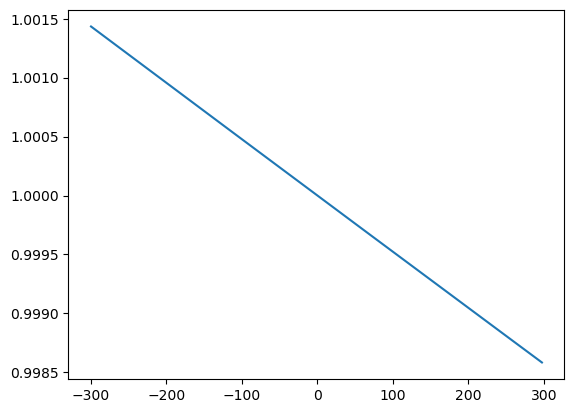

In [8]:
if __name__ == "__main__":
    a,b,c,d=factor(specfile='/data/Atlas9_Grid/grids/gridp05k2Yp02odfnew/fp05hep02t40000g45k2odfnew.dat',spectype='ATLAS9',band='U',RV_min=-300,RV_max=300)
    import matplotlib.pyplot as plt 
    plt.plot(c,d)